In [501]:
import time

import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
from toolsets.search import string_search
import os
import pandas as pd
from toolsets.file_io import get_file_list
import toolsets.T_rex as trx
import toolsets.raw_data_scaffold as rds
import seaborn as sns
from toolsets.constants import iso_steps
# master_dir = '/Volumes/Samsung_T5/'
# mzml_dir = os.path.join(master_dir, 'pos', 'mzml')
# eic_dir = os.path.join(master_dir, 'pos', 'eic')
# pl_dir = os.path.join(master_dir, 'pos', 'eic')
# from toolsets.search import search_feature, quick_search_values,string_search, quick_search_sorted
# for f in [mzml_dir, eic_dir, pl_dir]:
#     if os.path.exists(f)==False:
#         os.makedirs(f)
file_list = get_file_list(mzml_dir, '.mzML', with_tail=False)
import scipy
from scipy.signal import find_peaks, peak_prominences
from tqdm import tqdm
n_neighbor=1
intensity_threshold = 30000

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [502]:
std_list = pd.read_csv(os.path.join(master_dir, 'pos', 'std_list_pos_adduct.csv'))

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/New Volume/polyphenol_c18/pos/std_list_pos_adduct.csv'

In [6]:
ms1, ms2 = rds.read_mzml(file_list[0], mzml_dir)

In [336]:
def find_seed_info(intensity_sorted_indexing, mass_sorted, intensity_sorted, index_sorted):
    seed_idx = np.argmax(intensity_sorted_indexing)
    mass_tolerance = 0.005
    seed_mass = mass_sorted[seed_idx]
    left_idx, right_idx = mass_sorted.searchsorted([seed_mass-mass_tolerance, seed_mass+mass_tolerance])
    # offsets = np.abs(mass_sorted[left_idx:right_idx]-seed_mass)
    # mass_tolerance = np.mean(offsets)+3*np.std(offsets)
    ion_trace = trx.flash_eic(seed_mass, mass_sorted, intensity_sorted, index_sorted, mass_error=mass_tolerance)

    seed_index = index_sorted[seed_idx]
    roi_left, roi_right = search_edge_bidirection(ion_trace, seed_index)
    return(seed_mass, left_idx, right_idx, roi_left, roi_right, ion_trace)
def search_edge_bidirection(ion_trace, seed_index, max_allowed_empty_scan = 2):
    nz = np.nonzero(ion_trace)[0]
    # seed_index_range_s = seed_index_range.copy()
    diff_abs = (np.diff(nz))
    l, r = nz.searchsorted([seed_index-0.5, seed_index+0.5])
    if l ==r:
        return(np.NAN, np.NAN)# seed index not exist
    if l >0:
        offset_l = 1
        while l-offset_l>=0:
            if diff_abs[l-offset_l]<=max_allowed_empty_scan:
                offset_l = offset_l+1
            else:
                break
        offset_l = offset_l-1
    else:
        offset_l=0
    if r<len(nz):
        offset_r = -1
        while r+offset_r<len(diff_abs):
            if diff_abs[r+offset_r]<=max_allowed_empty_scan:
                offset_r = offset_r+1
            else:
                break
    else:
        offset_r = -1
    return(nz[l-offset_l], nz[r+offset_r])

# below is just for benchmarking purposes

In [504]:
ms1, ms2 = rds.read_mzml('SA1', '/Users/fanzhoukong/Documents/GitHub/Libgen_data/benchmarking_dataset/mzml')



In [221]:
mass_sorted, intensity_sorted, index_sorted, rt_list = trx.build_index(ms1)

In [421]:
order = np.argsort(intensity_sorted)

In [564]:
mass_indexing = mass_sorted[order]
mass_indexing = np.flip(mass_indexing)
intensity_indexing = intensity_sorted[order]
intensity_indexing = np.flip(intensity_indexing)

In [581]:
eic_center = np.zeros(len(mass_indexing))
eic_center[0] = mass_indexing[0]


counter = 1
for idx in tqdm(range(1, len(mass_indexing))):
    if intensity_indexing[idx]<30000:
        break
    if np.min(np.abs(mass_indexing[idx]-eic_center[0:counter]))>mass_indexing[idx]*10/1E6:
        ion_trace = trx.flash_eic_single(mass_indexing[idx], mass_sorted, intensity_sorted, index_sorted, mass_error= mass_indexing[idx]*10/1E6)
        eic_center[counter]=eic_center[counter]+mass_indexing[idx]
        counter = counter+1


 45%|████▌     | 4985745/11078731 [02:56<03:35, 28281.80it/s]


In [578]:
ion_trace = trx.flash_eic_single(mass_indexing[idx], mass_sorted, intensity_sorted, index_sorted, mass_error= mass_indexing[idx]*10/1E6)

In [555]:
eic_center[1509]

109.07604891638242

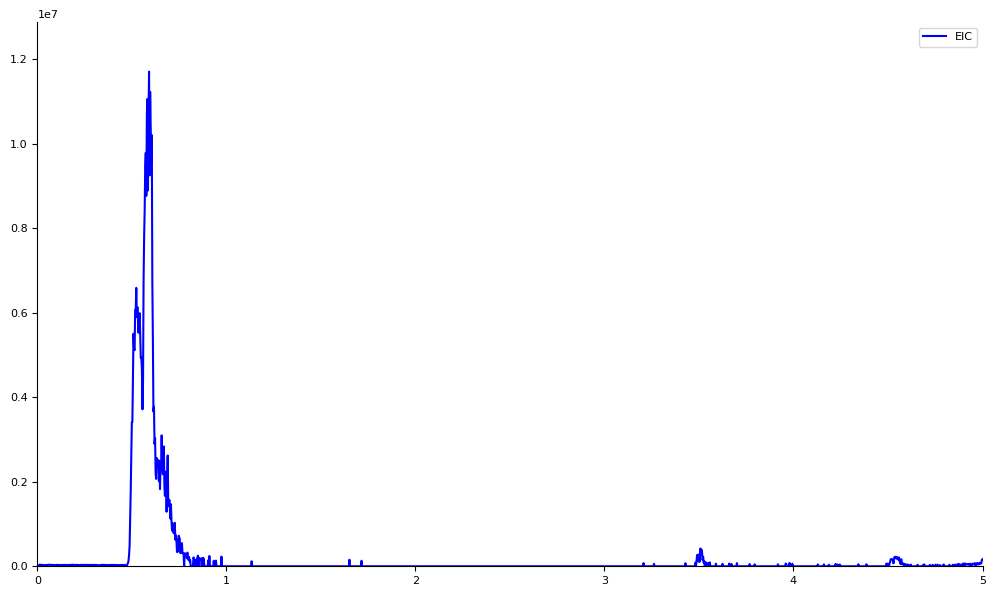

In [560]:
ion_trace1 = trx.flash_eic_single(109.07604891638242, mass_sorted, intensity_sorted, index_sorted, mass_error=0.005)
rds.EIC(rt_list,
        ion_trace1,
        # trx.gap_filling(ion_trace1),
        rt_start=0, rt_end=5
        )

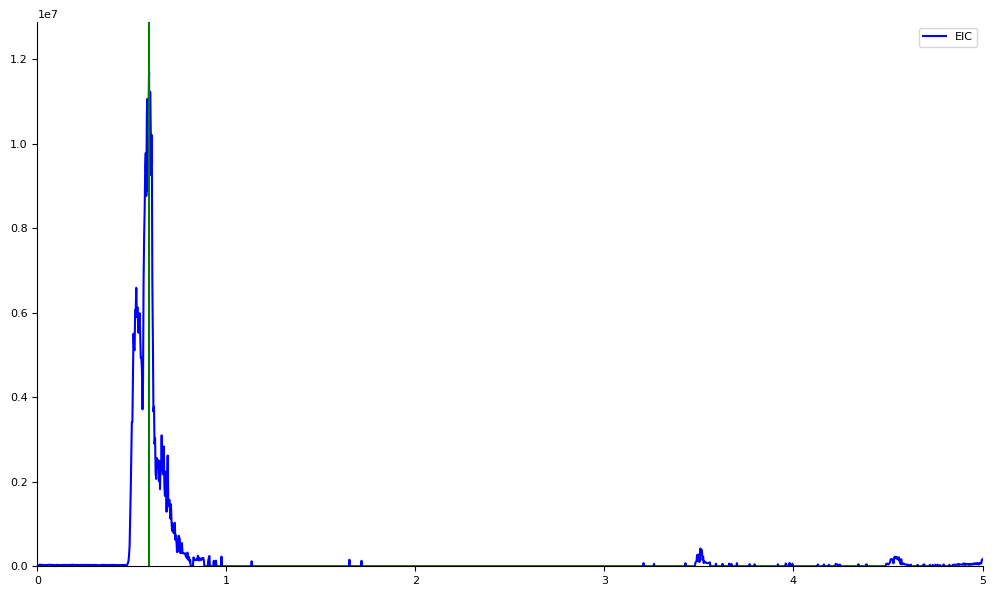

In [562]:
rds.EIC(rt_list,
        # ion_trace1,
        trx.gap_filling(ion_trace1),
        rt_start=0, rt_end=5,vlines_location_2=[0.59]
        )

In [476]:
baseline = pybaselines.smooth.snip(
    intensity_list_smoothed,filter_order=2,
    # max_half_window=20,
    )[0]
baseline = np.array([0 if x <0 else x for x in baseline])

In [480]:
trx.detect_all_peaks(intensity_list)

(array([[ 6032,  6133,  6348],
        [ 3018,  3090,  3266],
        [10403, 10602, 10978],
        [10978, 11023, 11171],
        [10348, 10387, 10403],
        [ 9971,  9979,  9997],
        [10005, 10024, 10052],
        [10302, 10334, 10348],
        [ 3266,  3267,  3318],
        [11224, 11298, 11323],
        [10076, 10094, 10106],
        [10152, 10172, 10183],
        [10239, 10244, 10277],
        [10277, 10284, 10295],
        [10222, 10237, 10239],
        [ 7734,  7780,  7801],
        [11171, 11173, 11193],
        [11207, 11222, 11224],
        [10054, 10069, 10076],
        [ 6348,  6353,  6359],
        [ 6359,  6364,  6473],
        [11193, 11198, 11207],
        [10198, 10209, 10214],
        [10129, 10133, 10143],
        [10115, 10121, 10129],
        [10143, 10148, 10152],
        [ 3419,  3432,  3444],
        [ 8584,  8610,  8625],
        [ 3325,  3331,  3350],
        [ 3315,  3324,  3325],
        [ 3444,  3460,  3479]]),
 array([0., 0., 0., 0., 0., 0., 0., 0

In [490]:
ms1.iloc[10327]['peaks']

array([[  100.07591252, 17229.25585938],
       [  100.11219116, 49388.75      ],
       [  100.50991907, 37126.71875   ],
       ...,
       [  834.44263986, 15033.39550781],
       [  835.58224404, 14372.40527344],
       [  836.58137481, 15208.39746094]])

In [491]:
371.1617-371.163431

-0.0017310000000065884

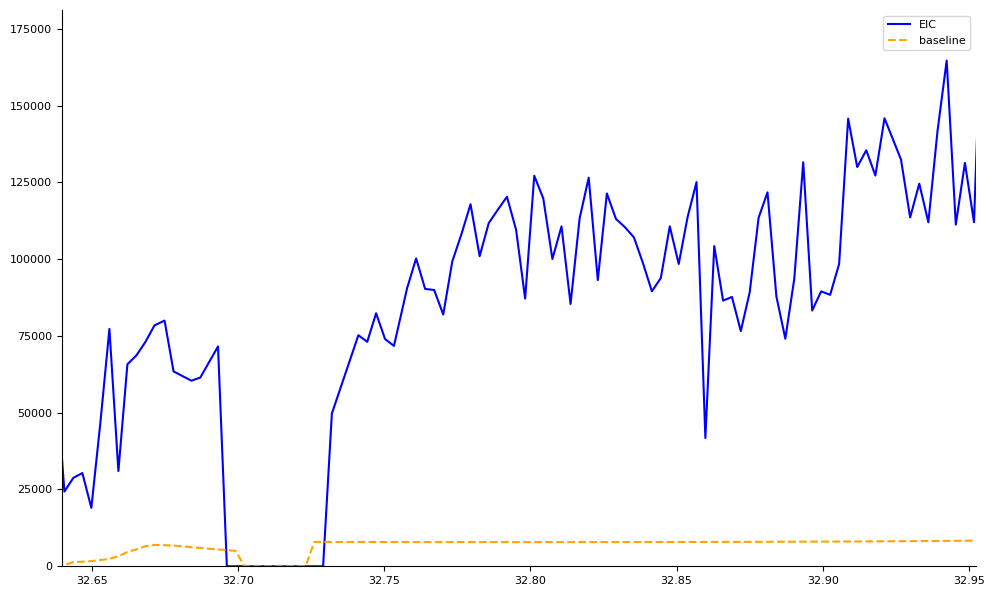

In [488]:
rds.EIC(rt_list, intensity_list,
        rt_start=rt_list[10302]-5/60, rt_end=rt_list[10349]+5/60,
        base_line_series=baseline,
        # vlines_location_2=[rt_list[11587]]
        )

In [300]:
intensity_list = trx.flash_eic(mass_sorted[np.argmax(intensity_sorted)], mass_sorted,intensity_sorted, index_sorted)

In [218]:
std_list = pd.read_csv(os.path.join( '/Users/fanzhoukong/Documents/GitHub/Libgen_data/benchmarking_dataset/','std_list.csv'))

In [329]:
%%timeit
zero_ranges= zero_runs(intensity_list)

22.6 µs ± 2.85 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [414]:
intensity_list = trx.flash_eic(179.017244522271, mass_sorted, intensity_sorted, index_sorted)

In [322]:
a = (intensity_list[zr[1]]-intensity_list[zr[0]-1])/(rt_list[zr[1]]-rt_list[zr[0]-1])

In [325]:
a*rt_list[zr[1]]+b

155202.890625

In [326]:
intensity_list[zr[1]]

155202.890625

In [282]:
diff = np.diff(zero_idx)

In [283]:
diff

array([], dtype=int64)

In [279]:
zero_idx[156]

201

In [275]:
np.where(diff>1)

(array([  155,   156,   157,   159,   160,   177,   213,   248,   279,
          286,   346,   374,   381,   385,   392,   443,   463,   465,
          474,   488,   508,   512,   522,   524,   536,   541,   542,
          546,   547,   549,   555,   562,   563,   564,   567,   570,
          571,   576,   579,   580,   581,   585,   586,   587,   588,
          589,   590,   591,   592,   594,   595,   596,   597,   598,
          599,   600,   601,   602,   603,   604,   605,   626,  1047,
         1048,  1053,  1054,  1055,  1058,  1060,  1084,  1183,  1214,
         1268,  1319,  1345,  1377,  1398,  1400,  1403,  1509,  2269,
         2272,  2273,  2274,  2278,  2403,  2808,  3127,  4252,  4326,
         4418,  4593,  4713,  4820,  4965,  5392,  5491,  5516,  5591,
         5596,  5598,  5602,  5603,  5604,  5605,  5606,  5717,  5753,
         5933,  6206,  7514,  7529,  7844,  8344,  8667,  9131,  9132,
         9133,  9153,  9191,  9206,  9215,  9271,  9312,  9345,  9467,
      

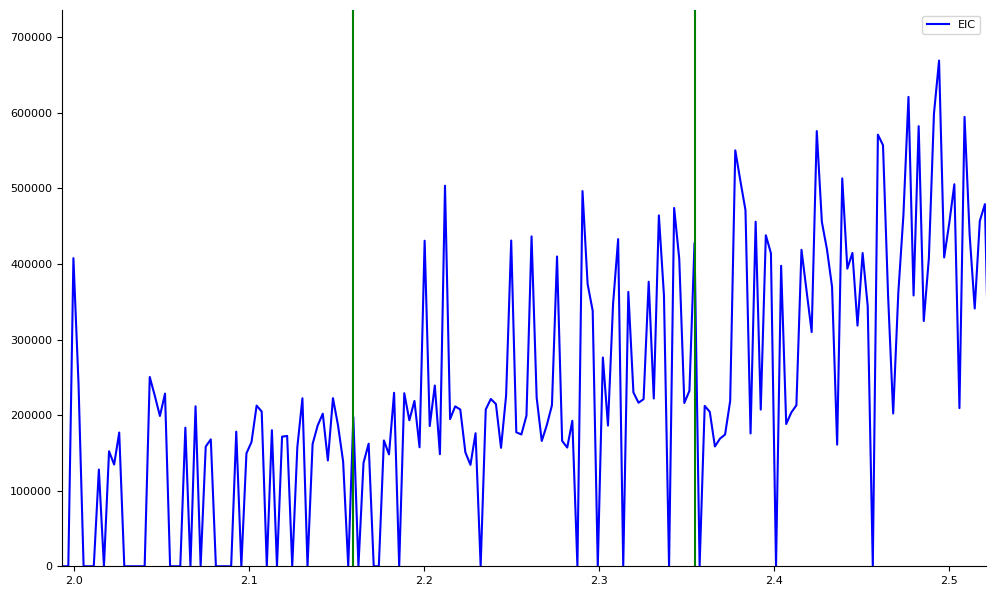

In [234]:
intensity_list = trx.flash_eic(200.1107, mass_sorted,intensity_sorted, index_sorted)
rds.EIC(rt_list, intensity_list, vlines_location_2=[rt_list[707], rt_list[774]],
        rt_start=rt_list[707]-10/60, rt_end=rt_list[774]+10/60)

In [265]:
600/60000

0.01

In [216]:
len(mass_sorted)

11078732

In [187]:
# diff = np.diff(mass)


In [189]:
%%timeit
mass, intensity = ms1['peaks'].iloc[0].T
mass_binned = np.zeros(len(mass))
intensity_binned = np.zeros(len(mass))
counter = 0
while len(mass)>0:
    seed_idx = np.argmax(intensity)
    seed_mass = mass[seed_idx]
    resolution = seed_mass/600000
    idx_left, idx_right = mass.searchsorted([seed_mass-3*resolution, seed_mass+3*resolution])
    tt = mass[idx_left:idx_right]
    mass_binned[counter]=seed_mass
    intensity_binned[counter]=intensity[seed_idx]
    mass = np.concatenate((mass[0:idx_left], mass[idx_right:]))
    intensity = np.concatenate((intensity[0:idx_left], intensity[idx_right:]))
    counter = counter+1#make sure this always the last line!
    # break


9.53 ms ± 67 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [205]:
peaks_binned

array([[  100.01437977,  1744.72546387],
       [  100.03961512,   904.71270752],
       [  100.07578132, 16707.60351562],
       ...,
       [  741.69564311,   710.65563965],
       [ 1018.82522052,   701.47869873],
       [ 1135.43740641,   732.60961914]])

In [201]:
np.empty([2, len(ms1)])

array([[ 0.00000000e+000,  0.00000000e+000, -1.13818014e-161, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000]])

In [149]:
from toolsets.spectra_plotter import ms2_plot
import toolsets.spectra_operations as so

In [156]:
np.diff(mass)

array([2.52353446e-02, 3.61661991e-02, 3.63714400e-02, ...,
       1.20103763e+01, 2.77129577e+02, 1.16612186e+02])

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

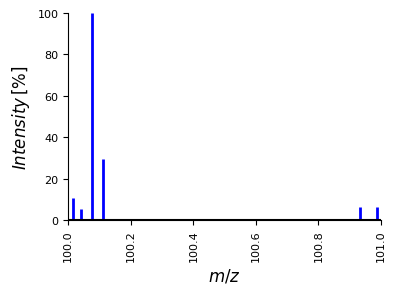

In [155]:
ms2_plot(so.pack_spectra(mass, intensity), lower=100, upper=101)

In [137]:
intensity

array([ 1744.72546387,   904.71270752, 16707.60351562, ...,
         710.65563965,   701.47869873,   732.60961914])

In [136]:
np.diff(mass)

array([2.52353446e-02, 3.61661991e-02, 3.63714400e-02, ...,
       1.20103763e+01, 2.77129577e+02, 1.16612186e+02])

In [126]:
mass_sorted, intensity_sorted, index_sorted, rt_list = trx.build_index(ms1)
mass_sorted_working = mass_sorted.copy()
intensity_sorted_working = intensity_sorted.copy()
index_sorted_working = index_sorted.copy()

In [127]:
np.max(intensity_sorted_working)

3246681856.0

In [116]:
seed_mass = mass_sorted[np.argmax(intensity_sorted)]

In [104]:
seed_mass = mass_sorted[np.argmin(intensity_sorted)]

In [107]:
%%timeit
ion_trace_single = trx.flash_eic_single(seed_mass, mass_sorted, intensity_sorted, index_sorted, len(ms1))

17.7 ms ± 3.56 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [112]:
lst = np.array([1,2,3,4,5,6])

In [117]:
while np.max(intensity_sorted_working)>30000:
    intensity_list, loc_used = trx.flash_eic_single(seed_mass, mass_sorted_working, intensity_sorted_working, index_sorted_working, len(ms1))
    mass_sorted_working = np.delete(mass_sorted_working, loc_used, axis=None)
    intensity_sorted_working=np.delete(intensity_sorted_working, loc_used, axis=None)
    index_sorted_working=np.delete(index_sorted_working, loc_used, axis=None)

In [125]:
np.max(intensity_sorted_working)

1409585664.0

In [124]:
seed_mass

179.01724452227148

In [119]:
intensity_list, loc_used = trx.flash_eic_single(seed_mass, mass_sorted_working, intensity_sorted_working, index_sorted_working, len(ms1))

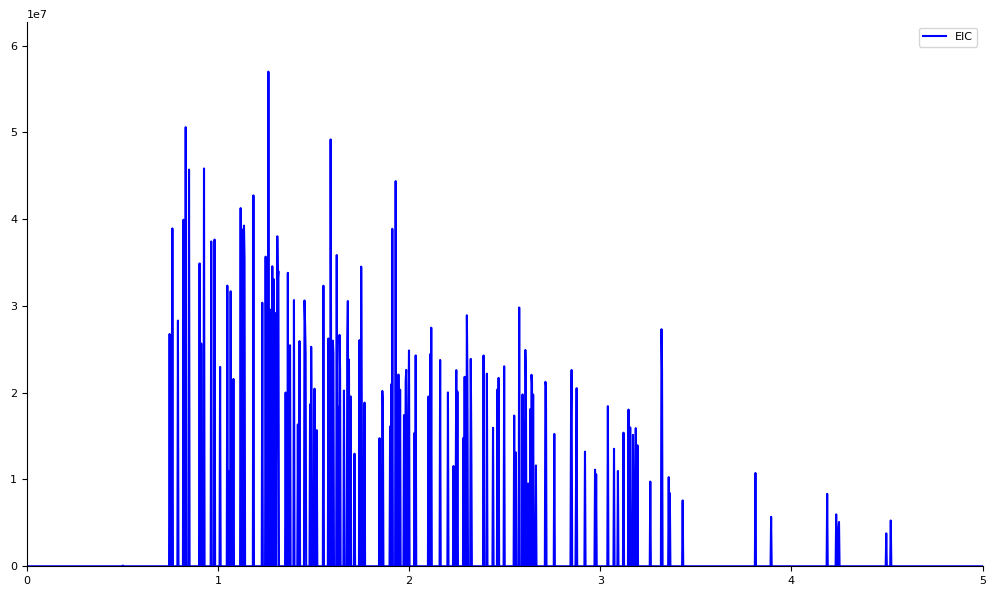

In [122]:
rds.EIC(rt_list, intensity_list,
        rt_start=0, rt_end=5)

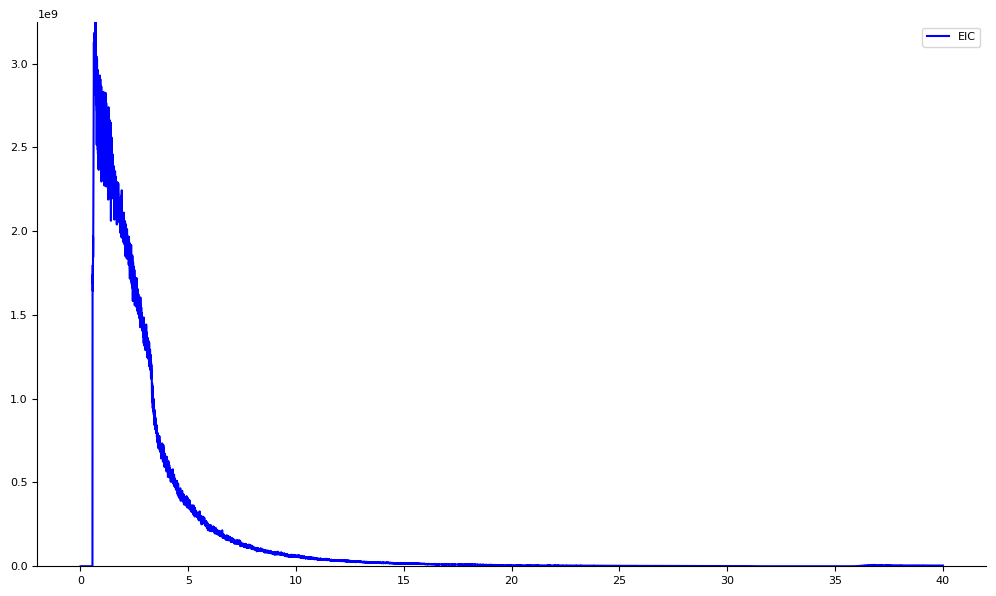

In [118]:
rds.EIC(rt_list, intensity_list, )

In [75]:
import peakutils
from peakutils.plot import plot as pplot

In [93]:
import pybaselines